In [120]:
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of batches of 32 images train_ds: 250
Number of batches of 32 images validation_ds: 32
Number of batches of 32 images test_ds: 32


/home/dracdarktime/miniconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


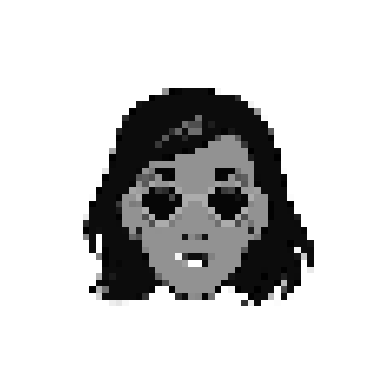

In [121]:
%run "../generacion_cartoon/data/0.1-drac-make_dataset.ipynb"
import generacion_cartoon.utils.paths as path
import notebooks.drac_CNVAE_gradient as CNVAE
import generacion_cartoon.visualization.visualize_CNVAE as visualize 
import tensorflow as tf
import time
import numpy as np

In [122]:
import tensorflow as tf

print("TensorFlow versión:", tf.__version__)
print("¿TensorFlow usa CUDA?:", tf.test.is_built_with_cuda())
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))
print("Dispositivo GPU:", tf.test.gpu_device_name())


TensorFlow versión: 2.18.0
¿TensorFlow usa CUDA?: True
GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Dispositivo GPU: /device:GPU:0


I0000 00:00:1747780965.390161    6530 gpu_device.cc:2022] Created device /device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [123]:
import mlflow
import dagshub

In [132]:
params ={'latent_dim':90,
 'epochs':10,
 'epsilon':0.001, 
 'beta':0.1} 


model = CNVAE.CNVAE(latent_dim=params['latent_dim'], beta=params['beta'])

In [133]:
name_model = f'model_FCNVAE__dim={params["latent_dim"]}_epocs={params["epochs"]}_epsilon={params["epsilon"]}_beta={params["beta"]}.keras'
path_models = path.models_dir(name_model)
model.build(input_shape=(None, 56, 56, 1))

In [134]:
model.summary()


Encoder Summary:


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 27, 27, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 90)             │       973,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 992,346 (3.79 MB)

 Trainable params: 992,346 (3.79 MB)

 Non-trainable params: 0 (0.00 B)


Decoder Summary:


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 4900)           │       445,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_19 (Reshape)            │ (None, 7, 7, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_57             │ (None, 14, 14, 128)    │       115,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_58             │ (None, 28, 28, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_59             │ (None, 56, 56, 1)      │           577 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 635,597 (2.42 MB)

 Trainable params: 635,597 (2.42 MB)

 Non-trainable params: 0 (0.00 B)


Total trainable parameters: 1,627,943


In [137]:
dagshub.init(repo_owner='DRACDARKTIME', repo_name='VA_cartoon', mlflow=True)
mlflow.set_experiment("FCNVAE_dim_beta")
mlflow.start_run()
mlflow.log_params(params)

optimizer = tf.keras.optimizers.Adam(params['epsilon'])
model.compile(optimizer=optimizer, patience=10, params=params, path_models=path_models)
model.fit(train_ds)


mlflow.tensorflow.log_model(model, 'model')        
mlflow.end_run()
#name_gif = f'grid_CNVAE_epochs={params["epochs"]}_epsilon{params["epsilon"]}_alpha={params["alpha"]}_beta{params["beta"]}_gamma{params["gamma"]}.gif'
#visualize.create_gif(name_gif=name_gif, path_save_gif=path.data_created_dir('cnvae'))


Initialized MLflow to track repo "DRACDARKTIME/VA_cartoon"

Repository DRACDARKTIME/VA_cartoon initialized!

Best model saved with ELBO: 662.94 at epoch: 1
Epoch: 1, total_loss_train: 662.94, recons_loss_train: 641.73, grad_loss_train: 80.76, center_loss_train: 13.14, time_epoch: 16.58s
Best model saved with ELBO: 495.84 at epoch: 2
Epoch: 2, total_loss_train: 495.84, recons_loss_train: 479.76, grad_loss_train: 94.69, center_loss_train: 6.61, time_epoch: 16.38s
Best model saved with ELBO: 474.13 at epoch: 3
Epoch: 3, total_loss_train: 474.13, recons_loss_train: 459.79, grad_loss_train: 85.66, center_loss_train: 5.78, time_epoch: 16.00s
Best model saved with ELBO: 463.46 at epoch: 4
Epoch: 4, total_loss_train: 463.46, recons_loss_train: 449.25, grad_loss_train: 85.52, center_loss_train: 5.66, time_epoch: 15.92s
Best model saved with ELBO: 455.95 at epoch: 5
Epoch: 5, total_loss_train: 455.95, recons_loss_train: 441.65, grad_loss_train: 86.92, center_loss_train: 5.62, time_epoch: 16.32s
Best model saved with ELBO: 449.87 at epoch: 6
Epoch: 6, total_loss_train: 449.87, recons_loss_train: 435.61,

2025/05/20 16:47:16 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Epoch: 10, total_loss_train: 437.22, recons_loss_train: 423.37, grad_loss_train: 88.01, center_loss_train: 5.05, time_epoch: 16.06s


2025/05/20 16:47:23 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-01-14; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'generacion-cartoon'}
2025/05/20 16:47:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run glamorous-wolf-612 at: https://dagshub.com/DRACDARKTIME/VA_cartoon.mlflow/#/experiments/11/runs/8e4d5a2008764be9b509fe0f436693e2
🧪 View experiment at: https://dagshub.com/DRACDARKTIME/VA_cartoon.mlflow/#/experiments/11


In [136]:
mlflow.end_run()

🏃 View run spiffy-crane-89 at: https://dagshub.com/DRACDARKTIME/VA_cartoon.mlflow/#/experiments/11/runs/c3206795360a48e9bd3043e6377c64d3
🧪 View experiment at: https://dagshub.com/DRACDARKTIME/VA_cartoon.mlflow/#/experiments/11


In [139]:
from tensorflow.keras.models import load_model

modelo_load = load_model("modelo_cvae_64filtros.keras")


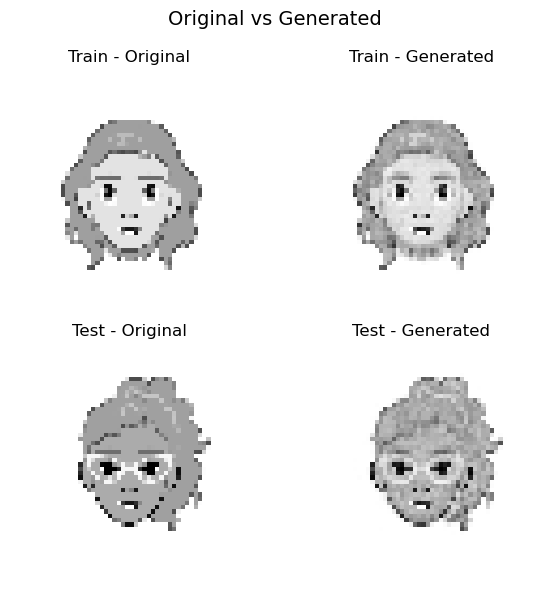

In [140]:
visualize.plot_original_vs_generated(model=model,num_img=20,test_ds=test_ds, train_ds=train_ds)

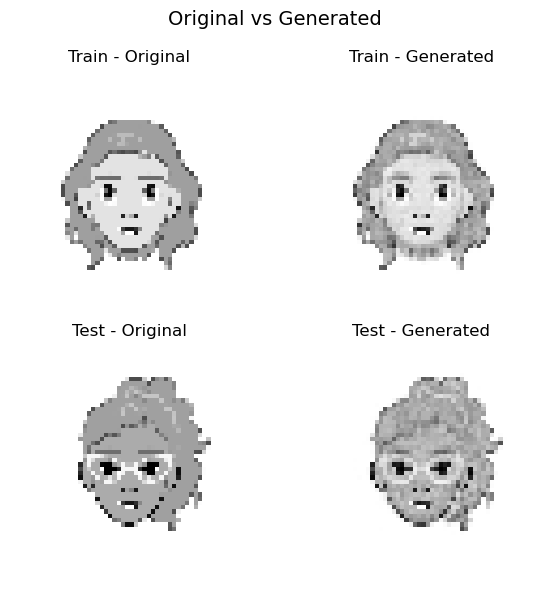

In [141]:
visualize.plot_original_vs_generated(model=modelo_load,num_img=20,test_ds=test_ds, train_ds=train_ds)

In [27]:
#visualize.plot_latent_images(model=model, num_images_x= 20, epoch=2, stan_des= 1, mean=0)